## Simulation Workflow

### Data
- Daily S&P 500 (SPX) open, high, low, and close (OHLC) data.
- Sample period starts in **2000**, covering multiple market cycles.

### Entry Design
- Construct an entry universe by randomly selecting **500 unique trading days** between **2000 and 2005**.
- A fixed random seed is used to ensure reproducibility.
- Each selected date represents **one independent investor** entering the market **once**, at the **closing price** of that day.

### Trade Setup
For each investor:
- **Stop-loss width** is varied from **0.5% to 15%** (100 evenly spaced levels).
- **Take-profit targets** are tested at **15%, 20%, 25%, and 30%**.
- Position size is fixed at one unit for all simulations.

### Exit Rules
For each (take-profit, stop-loss) pair, trades are simulated forward day by day until the first exit:
- If the **opening price** breaches the stop-loss or take-profit level, the position exits at the **opening price** (gap handling).
- Otherwise, if the **intraday low or high** reaches the stop-loss or take-profit level, the position exits at the corresponding **stop or target price**.
- If neither condition is met by the end of the sample, the position exits at the **final closing price**.

### Aggregation and Evaluation
- Results are aggregated across the **500 independent investors**.
- For each (take-profit, stop-loss) combination, the following metrics are computed:
  - **Win rate**
  - **Payoff ratio** (average gain divided by average loss)
  - **Average return** across investors

### Visualization
Three sets of curves are plotted against **stop-loss width (%)**, with separate lines for each take-profit level:
- **Win Rate vs. Stop-Loss**
- **Payoff Ratio vs. Stop-Loss**
- **Average Return vs. Stop-Loss**


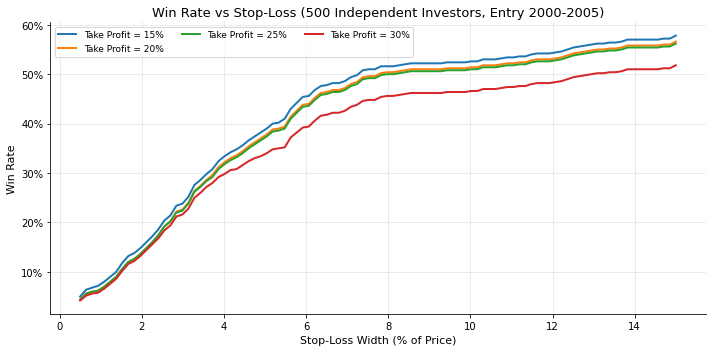

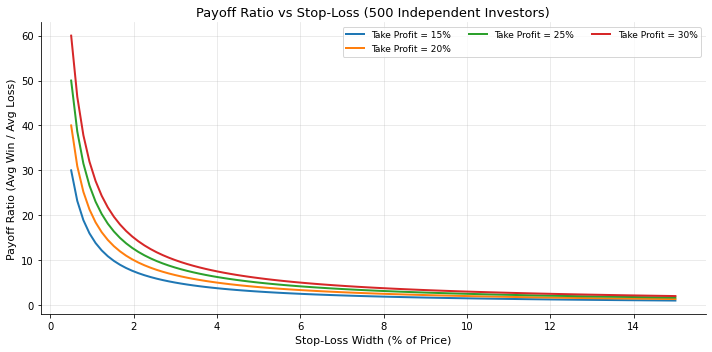

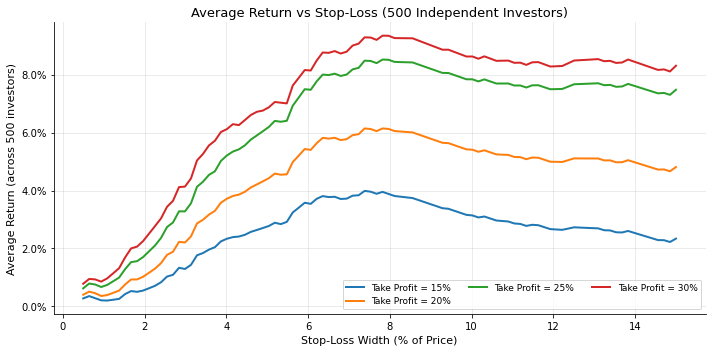

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

FILE_PATH = "/Users/charlesxiong/Desktop/IBKR_algo/ode/data/SPX/SPX_DT.xlsx"
OPEN_COL, HIGH_COL, LOW_COL, CLOSE_COL = "SPXopen", "SPXhigh", "SPXlow", "SPXclose"

# =========================
# Parameters
# =========================
N_ENTRIES = 500
STOP_LEVELS = np.linspace(0.005, 0.15, 100)           # 0.5% ~ 10%
TARGET_LEVELS = np.arange(0.15, 0.30001, 0.05)        # 10%, 20%, 30% (你当前写的是这个)

START_YEAR = 2000

ENTRY_START_YEAR = 2000
ENTRY_END_YEAR = 2005

SEED = 7
OUT_PREFIX = "randomentry_2000_2005_tp10_30_stop_sweep_independent"

# =========================
# Load data
# =========================
df = pd.read_excel(FILE_PATH)
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values("DateTime").reset_index(drop=True)
df = df[df.DateTime.dt.year >= START_YEAR].reset_index(drop=True)

o = df[OPEN_COL].to_numpy()
h = df[HIGH_COL].to_numpy()
l = df[LOW_COL].to_numpy()
c = df[CLOSE_COL].to_numpy()
n = len(df)

# =========================
# Restrict entry universe: 2000–2005
# =========================
entry_mask = (
    (df["DateTime"].dt.year >= ENTRY_START_YEAR) &
    (df["DateTime"].dt.year <= ENTRY_END_YEAR)
)

entry_pool = np.where(entry_mask.to_numpy())[0]
entry_pool = entry_pool[entry_pool < n - 1]  # entry 后面至少还有一天

if len(entry_pool) < N_ENTRIES:
    raise ValueError(
        f"Not enough entry points in {ENTRY_START_YEAR}-{ENTRY_END_YEAR}. "
        f"Have {len(entry_pool)}, need {N_ENTRIES}."
    )

rng = np.random.default_rng(SEED)
# 500个独立投资者：各自一个不同入场点（不放回）
entry_indices = rng.choice(entry_pool, size=N_ENTRIES, replace=False)
entry_indices = np.sort(entry_indices)

def simulate_one_trade(entry_idx: int, target: float, stop: float):
    """
    One independent investor:
    Entry reference = close[entry_idx]
    Exit rules (no double-hit handling):
      1) open <= SL -> exit at open
      2) open >= TP -> exit at open
      3) low <= SL -> exit at SL
      4) high >= TP -> exit at TP
      5) never hit until end -> exit at last close
    Returns: (trade_return, hit_type)
    """
    entry_ref = c[entry_idx]
    tp_price = entry_ref * (1.0 + target)
    sl_price = entry_ref * (1.0 - stop)

    for t in range(entry_idx + 1, n):
        # gap at open
        if o[t] <= sl_price:
            return (o[t] / entry_ref) - 1.0, "SL"
        if o[t] >= tp_price:
            return (o[t] / entry_ref) - 1.0, "TP"

        # intraday
        if l[t] <= sl_price:
            return (sl_price / entry_ref) - 1.0, "SL"
        if h[t] >= tp_price:
            return (tp_price / entry_ref) - 1.0, "TP"

    return (c[-1] / entry_ref) - 1.0, "END"


def evaluate_target_stop(target: float, stop: float):
    trade_rets = np.empty(N_ENTRIES, dtype=float)
    hit_types = np.empty(N_ENTRIES, dtype=object)

    for i, idx in enumerate(entry_indices):
        r, ht = simulate_one_trade(idx, target, stop)
        trade_rets[i] = r
        hit_types[i] = ht

    # 500个独立投资者的横截面统计
    avg_return = trade_rets.mean()
    median_return = np.median(trade_rets)  # 可选：更稳健，你不想要就删
    win_rate = (trade_rets > 0).mean()

    wins = trade_rets[trade_rets > 0]
    losses = trade_rets[trade_rets < 0]
    if wins.size == 0 or losses.size == 0:
        payoff = np.nan
    else:
        payoff = wins.mean() / abs(losses.mean())

    return {
        "target": target,
        "stop": stop,
        "avg_return": avg_return,
        "median_return": median_return,
        "win_rate": win_rate,
        "payoff": payoff,
        "tp_rate": (hit_types == "TP").mean(),
        "sl_rate": (hit_types == "SL").mean(),
        "end_rate": (hit_types == "END").mean(),
    }


# =========================
# Sweep
# =========================
rows = []
for target in TARGET_LEVELS:
    for stop in STOP_LEVELS:
        rows.append(evaluate_target_stop(target, stop))

res_df = pd.DataFrame(rows)

# =========================
# Plot styling
# =========================
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2.0,
})

# =========================
# Figure 1: Win rate vs Stop (colored by target)
# =========================
fig, ax = plt.subplots()
for target in TARGET_LEVELS:
    tmp = res_df[res_df["target"] == target].sort_values("stop")
    ax.plot(tmp["stop"].to_numpy() * 100,
            tmp["win_rate"].to_numpy(),
            label=f"Take Profit = {int(round(target*100))}%")

ax.set_xlabel("Stop-Loss Width (% of Price)")
ax.set_ylabel("Win Rate")
ax.set_title(f"Win Rate vs Stop-Loss (500 Independent Investors, Entry {ENTRY_START_YEAR}-{ENTRY_END_YEAR})")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig1_winrate.png", dpi=300)
plt.show()

# =========================
# Figure 2: Payoff ratio vs Stop (colored by target)
# =========================
fig, ax = plt.subplots()
for target in TARGET_LEVELS:
    tmp = res_df[res_df["target"] == target].sort_values("stop")
    ax.plot(tmp["stop"].to_numpy() * 100,
            tmp["payoff"].to_numpy(),
            label=f"Take Profit = {int(round(target*100))}%")

ax.set_xlabel("Stop-Loss Width (% of Price)")
ax.set_ylabel("Payoff Ratio (Avg Win / Avg Loss)")
ax.set_title(f"Payoff Ratio vs Stop-Loss (500 Independent Investors)")
ax.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig2_payoff.png", dpi=300)
plt.show()

# =========================
# Figure 3: Average return vs Stop (colored by target)
# =========================
fig, ax = plt.subplots()
for target in TARGET_LEVELS:
    tmp = res_df[res_df["target"] == target].sort_values("stop")
    ax.plot(tmp["stop"].to_numpy() * 100,
            tmp["avg_return"].to_numpy(),
            label=f"Take Profit = {int(round(target*100))}%")

ax.set_xlabel("Stop-Loss Width (% of Price)")
ax.set_ylabel("Average Return (across 500 investors)")
ax.set_title(f"Average Return vs Stop-Loss (500 Independent Investors)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig3_avgreturn.png", dpi=300)
plt.show()
